### Ejercicio 2: Viaje del viajante con redes de Kohonen

#### Configuración y generación de ciudades aleatorias


In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [32]:
NUM_CITIES = 200

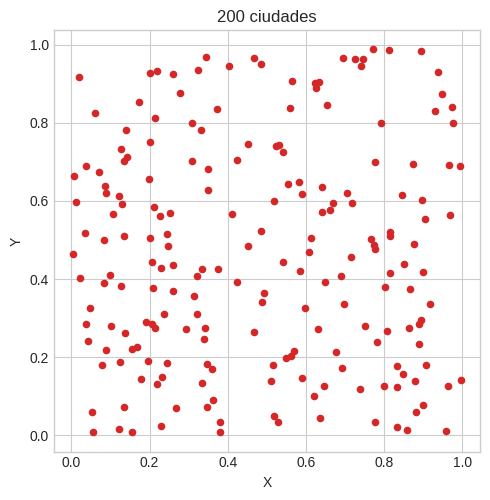

In [33]:
plt.style.use('seaborn-v0_8-whitegrid')
RNG = np.random.default_rng(2024)


cities = RNG.random((NUM_CITIES, 2))

fig, ax = plt.subplots(figsize=(5.5, 5.5))
ax.scatter(cities[:, 0], cities[:, 1], s=20, c='tab:red')
ax.set_title(f'{NUM_CITIES} ciudades')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal', 'box')
fig.savefig('/home/camila/Documents/Redes Neuronales/Redes-Neuronales/TP3/ejercicio-2/graficos/200-ciudades.png', dpi=200, bbox_inches='tight')
plt.show()

def euclidean_distance(p1, p2):
    return float(np.linalg.norm(p1 - p2))

def tour_distance(points):
    """
    Función para calcular por fuerza bruta la distancia euclídea entre las ciudades
    """
    total = 0.0
    for idx in range(len(points)):
        p_current = points[idx]
        p_next = points[(idx + 1) % len(points)]
        total += euclidean_distance(p_current, p_next)
    return total


In [22]:
best_len = float('inf')
best_tour = None

for perm in itertools.permutations(range(1, len(cities))):
    order = [0] + list(perm)  # fijar ciudad 0 como inicio
    route = cities[order]
    length = tour_distance(route)
    if length < best_len:
        best_len = length
        best_tour = route

print(f"Longitud camino óptimo para ({NUM_CITIES} ciudades): {best_len}")

Longitud camino óptimo para (10 ciudades): 3.1946399756713832


####  Red de Kohonen

In [37]:
class TSPKohonen:
    def __init__(self, n_neurons, input_dim=2, learning_rate=0.8, radius=None, semilla=0):
        self.n_neurons = n_neurons
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.rng = np.random.default_rng(semilla)
        angles = self.rng.uniform(0, 2 * np.pi, n_neurons)
        centroid = np.array([0.5, 0.5])
        radius_init = 0.4
        self.weights = centroid + radius_init * np.column_stack((np.cos(angles), np.sin(angles)))
        self.weights = np.clip(self.weights, 0.0, 1.0)
        self.initial_radius = radius if radius is not None else n_neurons / 2
        self.initial_radius = max(self.initial_radius, 1.0)

    def _winner(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=1)
        return np.argmin(distances)

    def _neighborhood(self, winner, radius):
        idx = np.arange(self.n_neurons)
        circular = np.minimum(np.abs(idx - winner), self.n_neurons - np.abs(idx - winner))
        return np.exp(-(circular ** 2) / (2 * (radius ** 2)))

    def train(self, data, iteraciones):
        time_constant = iteraciones / np.log(self.initial_radius)
        for epoch in range(iteraciones):
            sample = data[self.rng.integers(len(data))]
            lr = self.learning_rate * np.exp(-epoch / iteraciones)
            radius = self.initial_radius * np.exp(-epoch / time_constant)
            radius = max(radius, 1.0)
            winner = self._winner(sample)
            influence = self._neighborhood(winner, radius)[:, None]
            self.weights += influence * lr * (sample - self.weights)

    def route(self, data):
        indices = []
        for point in data:
            winner = self._winner(point)
            indices.append((winner, point))
        indices.sort(key=lambda t: t[0])
        ordered = np.array([p for _, p in indices])
        return ordered

    def tour_length(self, ordered_points):
        dist = np.linalg.norm(np.diff(np.vstack((ordered_points, ordered_points[:1])), axis=0), axis=1)
        return dist.sum()

#### Entrenamiento de la red

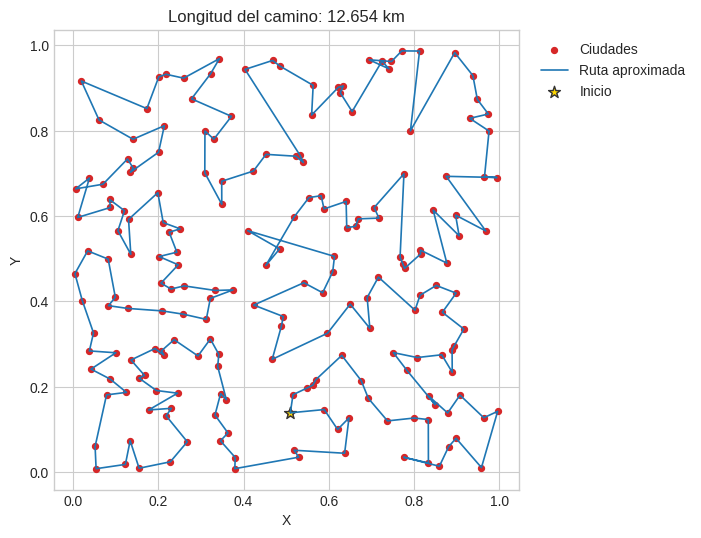

In [38]:
iteraciones = 6000
som_tsp = TSPKohonen(n_neurons=NUM_CITIES, semilla=None)
som_tsp.train(cities, iteraciones=iteraciones)

ordered_route = som_tsp.route(cities)
length = som_tsp.tour_length(ordered_route)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(cities[:, 0], cities[:, 1], c='tab:red', s=18, label='Ciudades')
ax.plot(ordered_route[:, 0], ordered_route[:, 1], c='tab:blue', linewidth=1.2, label='Ruta aproximada')
ax.plot([ordered_route[-1, 0], ordered_route[0, 0]], [ordered_route[-1, 1], ordered_route[0, 1]], c='tab:blue', linewidth=1.2)
ax.scatter(ordered_route[0, 0], ordered_route[0, 1], s=80, c='gold', edgecolors='0.2', marker='*', label='Inicio')
ax.set_title(f'Longitud del camino: {length:.3f} km')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
ax.set_aspect('equal', 'box')
fig.savefig('/home/camila/Documents/Redes Neuronales/Redes-Neuronales/TP3/ejercicio-2/graficos/resultado-200-ciudades-v2.png', dpi=200, bbox_inches='tight')
plt.show()